In [1]:
# Gotta fix the tracing of pixel scale with gaussian beamlet decomposition - maybe you can steal it from poppy?

In [2]:
import glets.raytrace as rt
import glets.gbd as gf
import glets.utils as ut
import numpy as np
import matplotlib.pyplot as plt
#!pip install poppy==1.0.0
#!pip install --upgrade pip # import poppy
#!pip install git+https://github.com/spacetelescope/poppy
import poppy
# print(poppy.__version__)
import sys
# sys.version
# !pip install numba

numexpr sees numcores =  96
numexpr sees numthreads =  96
numexpr sees max threads =  96
numba threads =  16


In [3]:
# Check numexpr cores
# import numexpr as ne
# print(ne.detect_number_of_cores())
# print(ne.ncores)
# ne.set_num_threads(64)
# print(ne.nthreads)
# print(ne.MAX_THREADS)

In [4]:
def kolphase(s):
    #phase=kolphaseClass(s)
    # Returns a random Kolmogorov phase screen of dimension s x s computed 
    # from the FT of random complex numbers with appropriate amplitudes. 
    # Screens are computed on a grid of size 2s, with a s x s piece cut out. 
    # This helps overcome the problem with this techniqe of under-representing 
    # tilt. Tandom tilts are also explicity added to give a reasonable 
    # approximation of the overall Kolmogorav structure function on all scales.
    ph=np.zeros([s,s,2]) #initialize phase variable
    [x,y]=np.meshgrid(range(-s,s),range(-s,s))
    r=np.sqrt(np.multiply(x,x)+np.multiply(y,y)) #make a radial ordinate
    
    f1=np.random.randn(2*s,2*s) #make two sets of gaussian random numbers
    f2=np.random.randn(2*s,2*s)
    
    f=f1+1j*f2 #turn the two random numbers into a complex random number
    ps=np.power(r,-11/6) #Kolomogorov power spectrum amplitude
    ps[s][s]=0; #setting the centr of the power spectrum (DC term) to zero
    
    scale=15.2 #this number makes the tilts work out 
    
    xt=np.random.randn(2)*(scale/s) #random amplitudes for tip and tilt to 
    yt=np.random.randn(2)*(scale/s) #mitigate power spectral rolloff at low frequencies 
    
    #This has Kolmogorov phases in real and imaginary parts
    sc= np.fft.fft2(np.fft.fftshift(np.multiply(np.multiply(np.abs(f),ps),np.exp(1j*np.angle(f))))) 
    
    #seperating the real and imaginary parts
    ph[:,:,0]=np.real(sc[0:s,0:s])+xt[0]*x[0:s,0:s]+yt[0]*y[0:s,0:s]
    ph[:,:,1]=np.real(sc[0:s,0:s])+xt[1]*x[0:s,0:s]+yt[1]*y[0:s,0:s]
    
    #make the mean phase zero
    ph[:,:,0]=ph[:,:,0]-np.mean(ph[:,:,0])
    ph[:,:,1]=ph[:,:,1]-np.mean(ph[:,:,1])
    
    #pick just one of the two phase screens for present purposes scale to 
    #something that will give reasonable ansewrs on a 1024 grid with 256 pupil
    ph=ph[:,:,1]*3
    
    return ph

def zernikeRadialFunc(n, m, r):
    """
    Fucntion to calculate the Zernike radial function

    Parameters:
        n (int): Zernike radial order
        m (int): Zernike azimuthal order
        r (ndarray): 2-d array of radii from the centre the array

    Returns:
        ndarray: The Zernike radial function
    """
    import numpy
    R = numpy.zeros(r.shape)
    for i in range(0, int((n - m) / 2) + 1):

        R += numpy.array(r**(n - 2 * i) * (((-1)**(i)) *
                         numpy.math.factorial(n - i)) /
                         (numpy.math.factorial(i) *
                          numpy.math.factorial(0.5 * (n + m) - i) *
                          numpy.math.factorial(0.5 * (n - m) - i)),
                         dtype='float')
    return R

def zernike_nm(n, m, N):
    """
     Creates the Zernike polynomial with radial index, n, and azimuthal index, m.

     Args:
        n (int): The radial order of the zernike mode
        m (int): The azimuthal order of the zernike mode
        N (int): The diameter of the zernike more in pixels
     Returns:
        ndarray: The Zernike mode
     """
    import numpy 
    coords = np.linspace(-1,1,N) + 1e-20
    X, Y = numpy.meshgrid(coords, coords)
    R = numpy.sqrt(X**2 + Y**2)
    theta = numpy.arctan2(Y, X)

    if m==0:
        Z = numpy.sqrt(n+1)*zernikeRadialFunc(n, 0, R)
    else:
        if m > 0: # j is even
            Z = numpy.sqrt(2*(n+1)) * zernikeRadialFunc(n, m, R) * numpy.cos(m*theta)
        else:   #i is odd
            m = abs(m)
            Z = numpy.sqrt(2*(n+1)) * zernikeRadialFunc(n, m, R) * numpy.sin(m * theta)

    # clip
    #Z = Z*numpy.less_equal(R, 1.0)

    return Z#*circle(N/2., N)

Fresnel Propagation Time =  22.702700099907815


Text(0.5, 0.98, 'After propagating 0.254 m')

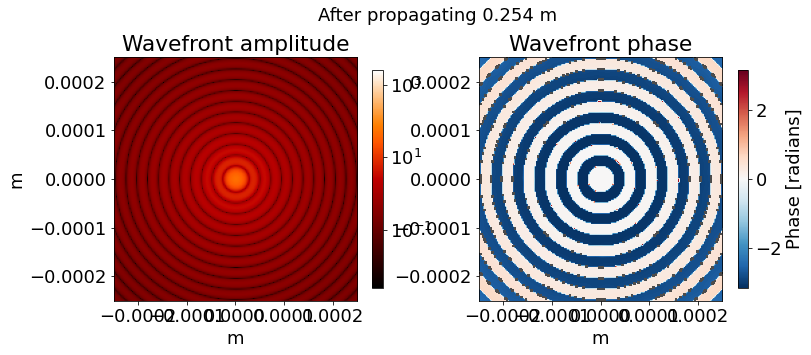

In [20]:
# Set up poppy osys
import time
nrays_across = 90
scale = 1
detector_size = 5e-4
wlen = 2.2e-6
npix = 512
size = 25.4e-3

import astropy.units as u

t1 = time.perf_counter()
wf = poppy.FresnelWavefront(size/2*u.m,wavelength=wlen,npix=npix,oversample=8)
circ = poppy.CircularAperture(radius=size/2*u.m)
zwfe = poppy.ZernikeWFE(coefficients=[0,0,0,0,0,2.2e-7*0],radius=4*size/2*u.m)
thin = poppy.QuadraticLens(10*size*u.m)

wf *= circ
wf *= zwfe
opd_to_pass = ut.grab_center(zwfe.get_opd(wf),npix/2)
wf *= thin
z = 10*size*u.m
wf.propagate_fresnel(z)
t2 = time.perf_counter()
print('Fresnel Propagation Time = ',t2-t1)

plt.figure(figsize=(12,5))
wf.display('both',colorbar=True,imagecrop=detector_size,scale='log')
plt.suptitle("After propagating {}".format(z), fontsize=18)


Preliminary Profiling for 90x90 gauslets on a 256x256 grid. 4 Cores, 16Gb ram per core.
- numpy = 35.92421955498867  s
- numba = 11.78987331292592  s
- numexpr = 35.87819419009611  s

In [6]:
wf.pixelscale

<Quantity 2.74999666e-06 m / pix>

Computing Derivative for Pixelscale of =  0.0002309090909090909
time to assemble phase array =  108.41377070266753
profiling numexpr
Time to compute exponential  17.397130256984383  s


<Figure size 432x288 with 0 Axes>

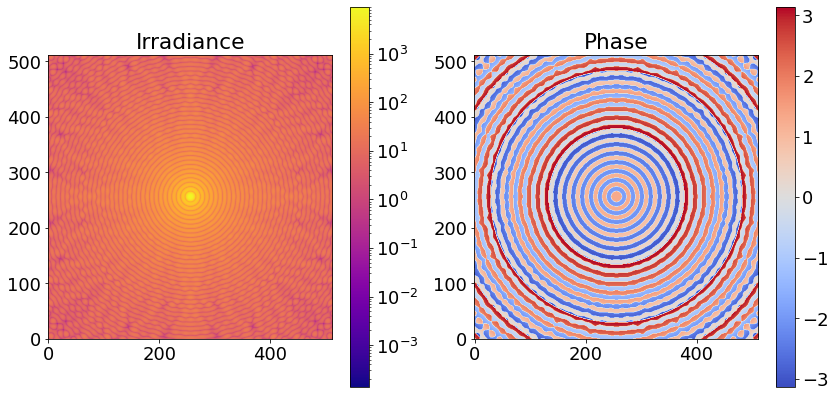

In [7]:
from scipy.ndimage import zoom
# Set up rays
nrays_across = 110
scale = 1
detector_size = 2.76499967e-6*512
wlen = 2.2e-6
npix = 512
size = 25.4e-3
rays = rt.makerays(25.4e-3, nrays_across,circle=False)

# Give rays some wavefront error
array = opd_to_pass#zernike_nm(3,-3,256)*1e-7 # kolphase(npix)*5e-9 # 
array_gbd = zoom(array,nrays_across/npix)
testrays = rt.ArbitraryWFE(nrays_across, size,rays,scale,array=array_gbd) # array assumes units of meters
nrays_total = int((rays.shape[1]))

# Set up a thin lens that goes to focus
lens = rt.ThinLens(254e-3, nrays_total)
dist = rt.FreeSpace(254e-3, nrays_total)
rayt = rt.matmultlist(lens, dist)
rayt = rt.matmultlist(dist,rayt)

raysincirc = testrays[:,np.sqrt(testrays[0,:]**2 + testrays[1,:]**2) <= 12.7e-3]
rtmincirc  = rayt[:,:,np.sqrt(testrays[0,:]**2 + testrays[1,:]**2) <= 12.7e-3]
efie_numerical = np.reshape(gf.eval_gausfield(raysincirc, rtmincirc, wlen, detector_size, npix,use_numexpr=True),[npix,npix])
ut.amp_phase_plot(efie_numerical,logintensity=True)

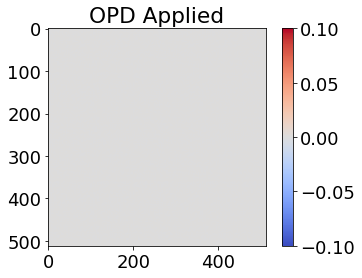

<Figure size 432x288 with 0 Axes>

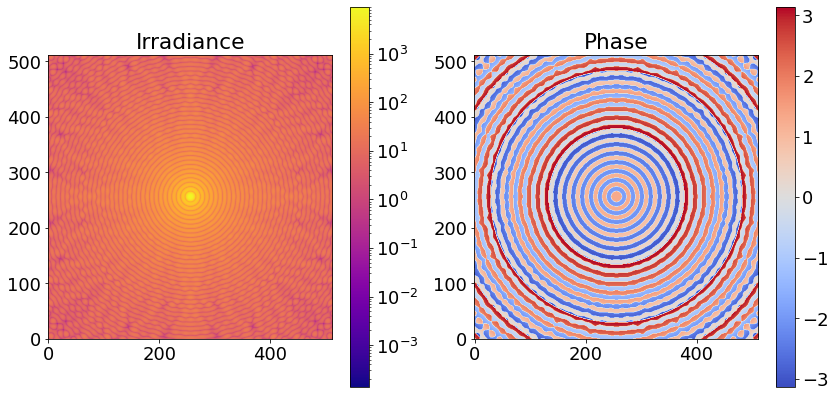

<Figure size 432x288 with 0 Axes>

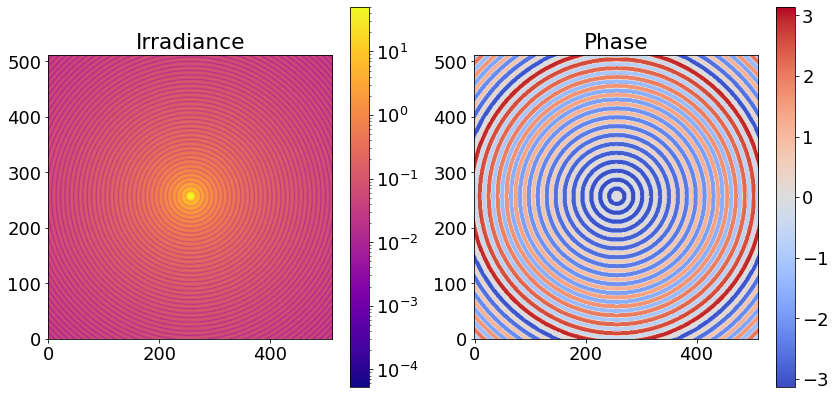

1.0.2.dev94+gbd13c76


<Figure size 432x288 with 0 Axes>

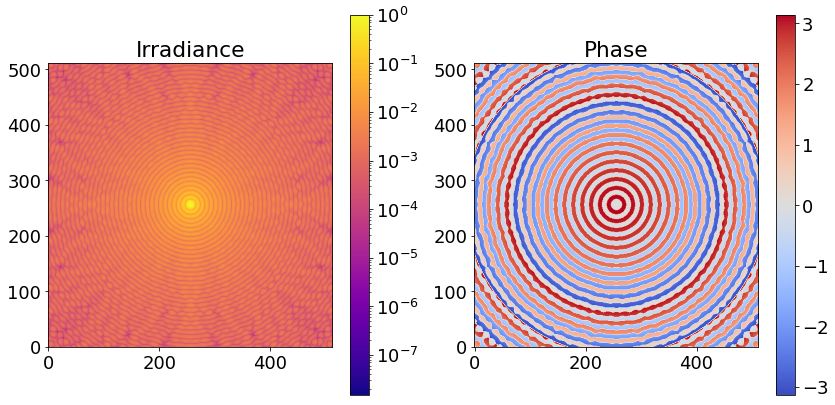

<Figure size 432x288 with 0 Axes>

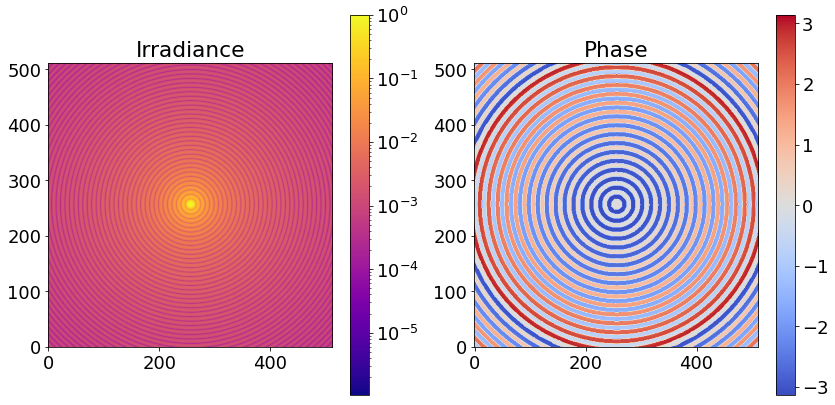

/home/u6/jashcraft/.local/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [8]:
plt.figure()
plt.title('OPD Applied')
plt.imshow(opd_to_pass)
plt.colorbar()
plt.show()

# grab PSF center
efie_fresnel = ut.grab_center(wf.wavefront,npix/2)

#efie_numerical /= np.sum(efie_numerical)
#efie_fresnel /= np.sum(efie_fresnel)

ut.amp_phase_plot(efie_numerical,logintensity=True)
ut.amp_phase_plot(efie_fresnel,logintensity=True)
print(poppy.__version__)

efie_numerical /= np.sum(efie_numerical)
efie_numerical /= np.max(efie_numerical)
efie_fresnel /= np.sum(efie_fresnel)
efie_fresnel /= np.max(efie_fresnel)


ut.amp_phase_plot(efie_numerical,logintensity=True)
ut.amp_phase_plot(efie_fresnel,logintensity=True)

# make wavefronts
wfg = poppy.FresnelWavefront(beam_radius=5e-4/2*u.m,npix=256,oversample=2,wavelength=2.2e-6*u.m)
wff = poppy.FresnelWavefront(beam_radius=5e-4/2*u.m,npix=256,oversample=2,wavelength=2.2e-6*u.m)
wfg.wavefront = zoom(efie_numerical,1)
wff.wavefront = zoom(efie_fresnel,1)

def propagate_lyot(wfarray):
    
    osys = poppy.FresnelOpticalSystem(npix=256, beam_ratio=2)
    #osys.add_optic(poppy.ScalarTransmission())
    osys.add_optic(poppy.InverseTransmission(poppy.CircularAperture(radius=2.5e-5*2*u.m)))
    osys.add_optic(poppy.QuadraticLens(254e-3*u.m),distance=254e-3*u.m)
    osys.add_optic(poppy.CircularAperture(radius=25.4e-3*0.9*u.m),distance=254e-3*u.m)
    osys.add_optic(poppy.QuadraticLens(254e-3*u.m),distance=254e-3*u.m)
    osys.add_optic(poppy.ScalarTransmission(),distance=254e-3*u.m)
    psf = osys.calc_psf(wavelength=2.2e-6*u.m,inwave=wfarray)
    
    return psf

psfg = propagate_lyot(wfg)
psff = propagate_lyot(wff)

In [9]:
# Compute Coronagraphic Profiles
gbd_pro = poppy.radial_profile(psfg)
fnl_pro = poppy.radial_profile(psff)
dif_pro = gbd_pro[1]-fnl_pro[1]

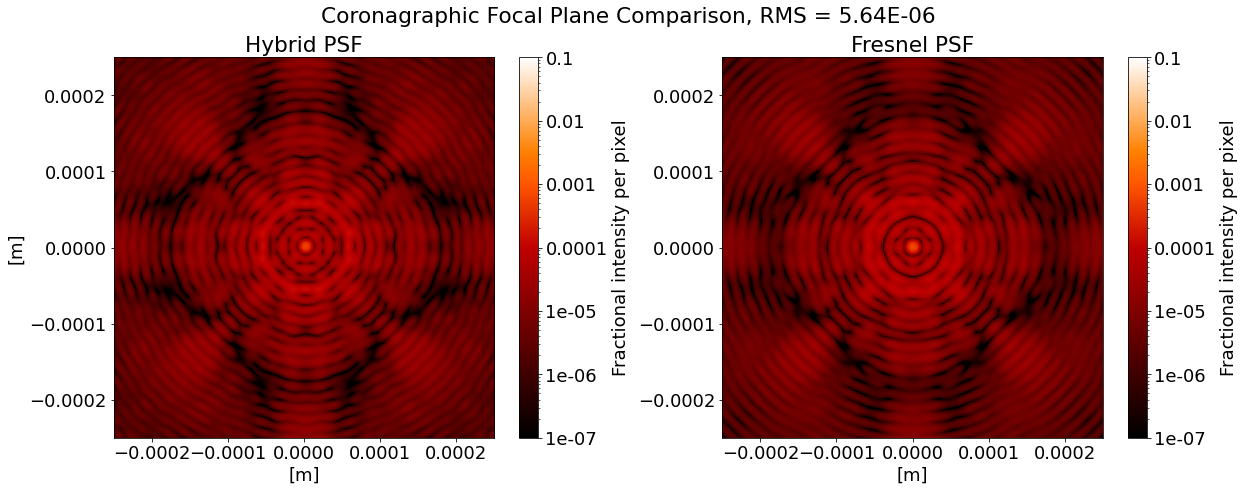

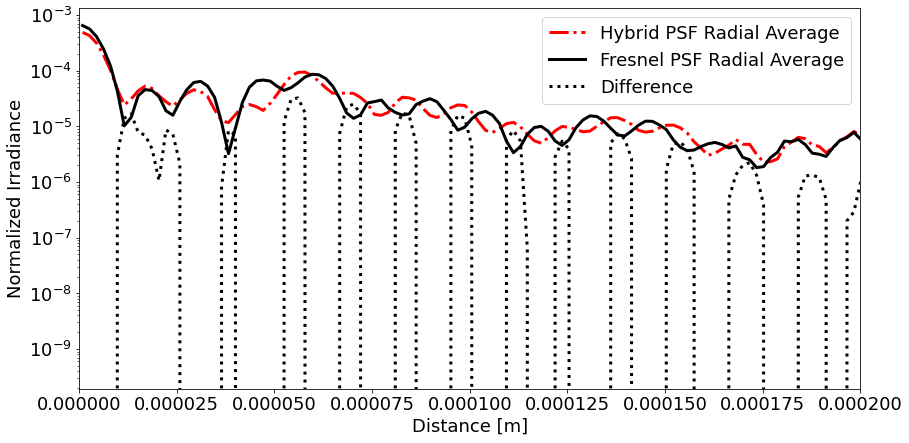

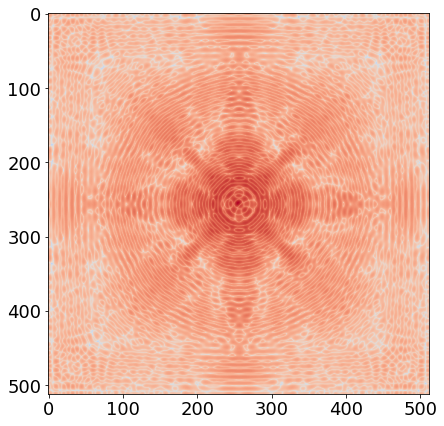

In [24]:
plt.figure(figsize=[20,7])
plt.suptitle('Coronagraphic Focal Plane Comparison, RMS = {:.2E}'.format(np.std(psfg[0].data-psff[0].data)))
plt.subplot(121)
poppy.display_psf(psfg,imagecrop=5e-4,title='Hybrid PSF')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.subplot(122)
poppy.display_psf(psff,imagecrop=5e-4,title='Fresnel PSF')
plt.xlabel('[m]')
plt.show()
plt.figure(figsize=[14,7])
plt.plot(gbd_pro[0],gbd_pro[1],label='Hybrid PSF Radial Average',color='red',linewidth=3,linestyle='dashdot')
plt.plot(gbd_pro[0],fnl_pro[1],label='Fresnel PSF Radial Average',color='black',linewidth=3,linestyle='solid')
plt.plot(gbd_pro[0],dif_pro,label='Difference',color='black',linewidth=3,linestyle='dotted')
plt.yscale('log')
plt.xlim([0,.0002])
plt.ylabel('Normalized Irradiance')
plt.xlabel('Distance [m]')
plt.legend()
plt.show()


from matplotlib.colors import LogNorm
plt.figure(figsize=[7,7])
plt.imshow(np.abs(psfg[0].data-psff[0].data),norm=LogNorm())
plt.show()

In [11]:

psff[0].header['PIXELSCL']#-psfg[0].header['PIXELSCL']

1.779094188515132e-06

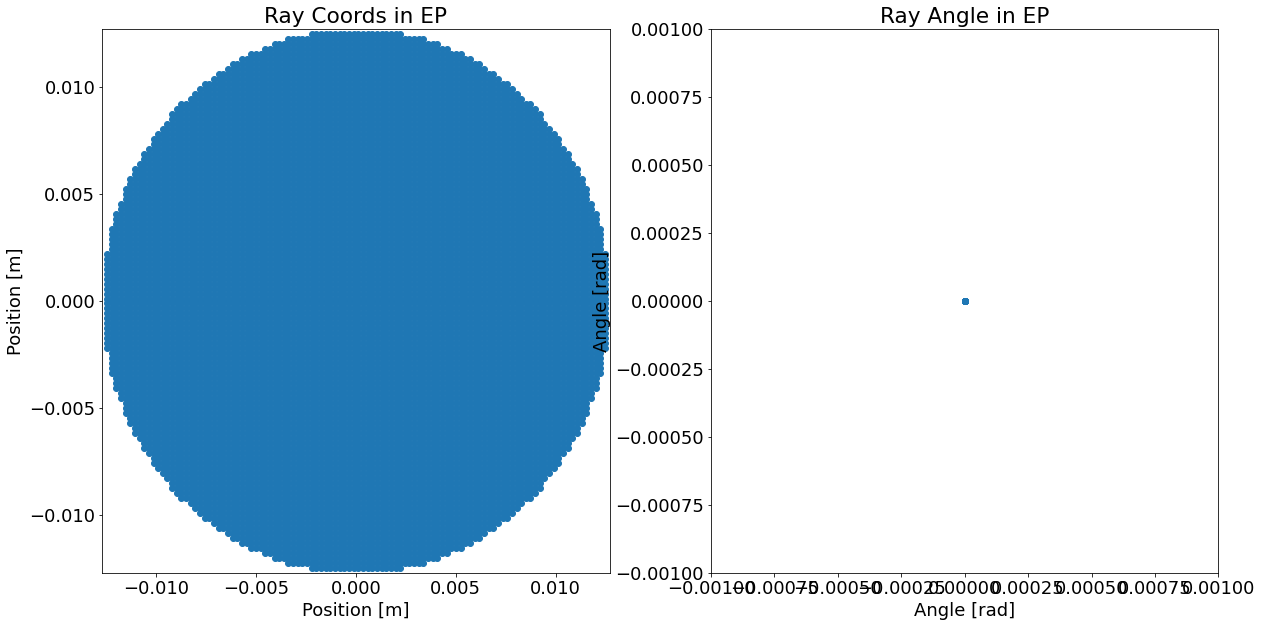

In [12]:
angle=1e-3
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.title('Ray Coords in EP')
plt.scatter(raysincirc[0,:],raysincirc[1,:])
plt.xlabel('Position [m]')
plt.ylabel('Position [m]')
plt.xlim([-size/2,size/2])
plt.ylim([-size/2,size/2])
plt.subplot(122)
plt.title('Ray Angle in EP')
plt.scatter(raysincirc[2,:],raysincirc[3,:])
plt.xlabel('Angle [rad]')
plt.ylabel('Angle [rad]')
plt.xlim([-angle,angle])
plt.ylim([-angle,angle])
plt.show()

<Figure size 432x288 with 0 Axes>

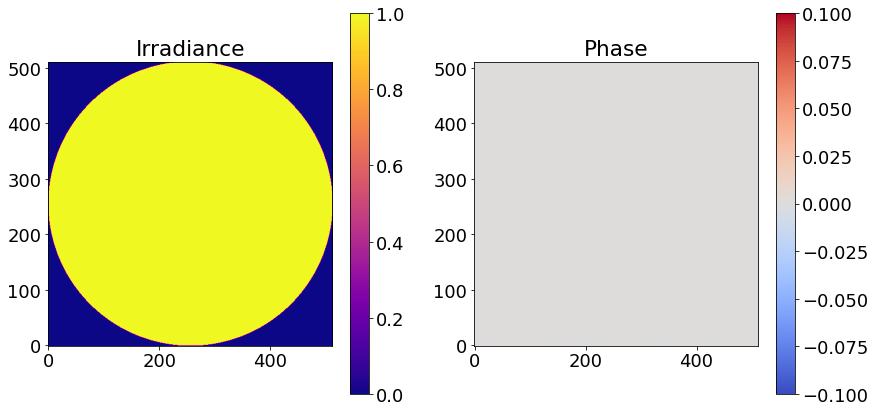

In [13]:
size = 25.4e-3
x = np.linspace(-size/2,size/2,npix)
x,y = np.meshgrid(x,x)
field = np.exp(1j*2*np.pi/(wlen)*array)
field[np.sqrt(x**2 + y**2) >= size/2] = 0
ut.amp_phase_plot(field,logintensity=False)
efie_fourier = ut.zeropadft(field,8)

<Figure size 432x288 with 0 Axes>

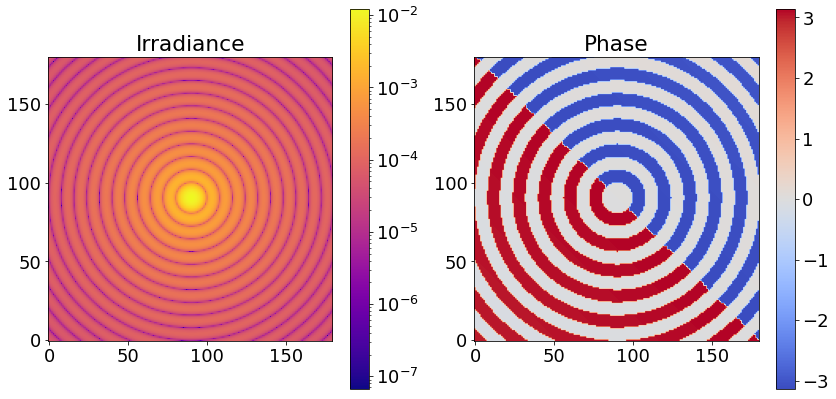

<Figure size 432x288 with 0 Axes>

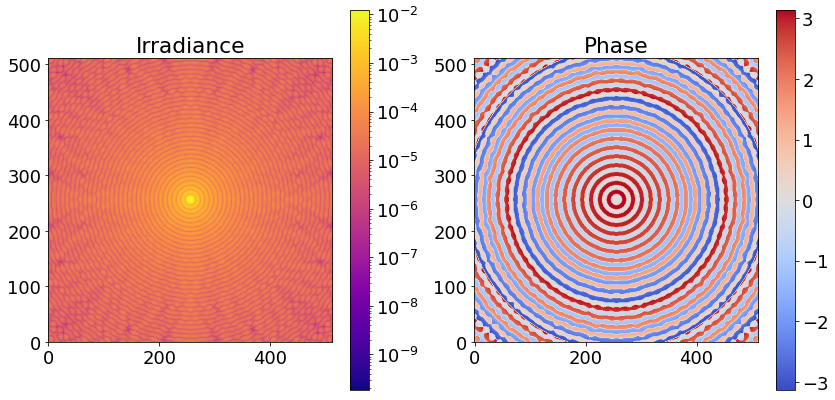

In [14]:
efie_fourier /= np.sum(efie_fourier)
efie_numerical /= np.sum(efie_numerical)
ut.amp_phase_plot(ut.grab_center(efie_fourier,90),logintensity=True)
ut.amp_phase_plot(np.flip(efie_numerical,axis=0),logintensity=True)

In [15]:
nb_core1 = [11.827077703084797,11.948099514003843,11.858216507826,11.831318301847205,12.10197844891809]
nb_core2 = [6.830082910135388,6.764931800076738,6.664175349986181,6.702146718977019,6.658429739996791]
nb_core4 = [4.068105740007013,4.237727437866852,4.051255834987387,4.0580868979450315,4.05311485985294]
nb_core8 = [2.7503048460930586,2.7183259329758584,2.886333044851199,2.7778676180168986,2.771433771122247]
nb_core16 = [2.5566316361073405,2.5813044789247215,2.682272502919659,2.724451190093532,2.9462854070588946]

ne_core1 = [11.103700865991414,11.080216636881232,11.165246736025438,11.081090769963339,11.080760715994984]
ne_core2 = []
ne_core4 = []
ne_core8 = []
ne_core16 = []

def compute_mean_std(data):
    return np.mean(data),np.std(data)

nb_core1_mean,nb_core1_std = compute_mean_std(nb_core1)
nb_core2_mean,nb_core2_std = compute_mean_std(nb_core2)
nb_core4_mean,nb_core4_std = compute_mean_std(nb_core4)
nb_core8_mean,nb_core8_std = compute_mean_std(nb_core8)
nb_core16_mean,nb_core16_std = compute_mean_std(nb_core16)

ne_core1_mean,ne_core1_std = compute_mean_std(ne_core1)
ne_core2_mean,ne_core2_std = compute_mean_std(ne_core2)
ne_core4_mean,ne_core4_std = compute_mean_std(ne_core4)
ne_core8_mean,ne_core8_std = compute_mean_std(ne_core8)
ne_core16_mean,ne_core16_std = compute_mean_std(ne_core16)
labels = ['1','2','4','8','16']

/home/u6/jashcraft/.conda/envs/py38v/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/u6/jashcraft/.conda/envs/py38v/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/u6/jashcraft/.conda/envs/py38v/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/u6/jashcraft/.conda/envs/py38v/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/u6/jashcraft/.conda/envs/py38v/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of ticklabels (5).

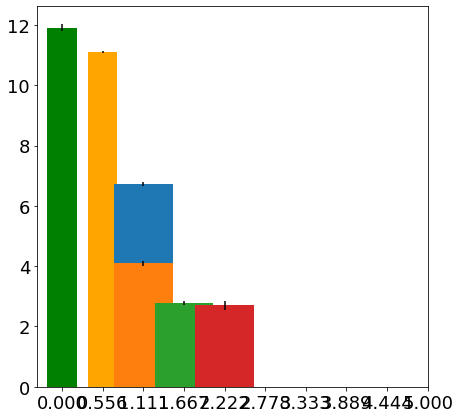

In [16]:
x = np.linspace(0,5,10)
fig,ax = plt.subplots(figsize=[7,7])
ax.bar(x[0],nb_core1_mean,yerr=nb_core1_std,color='green',width=0.4)
ax.bar(x[1],ne_core1_mean,yerr=ne_core1_std,color='orange',width=0.4)
ax.bar(x[2],nb_core2_mean,yerr=nb_core2_std)
ax.bar(x[2],nb_core4_mean,yerr=nb_core4_std)
ax.bar(x[3],nb_core8_mean,yerr=nb_core8_std)
ax.bar(x[4],nb_core16_mean,yerr=nb_core16_std)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.yaxis.grid(True)
ax.set_title('1876 Beamlets, npix = {}'.format(npix))
ax.set_xlabel('Number of Cores')
ax.set_ylabel('Seconds')
plt.show()

In [ ]:
raysincirc.shape